# Production Diagnosis
**Objective:** Identify the root cause of underperformance by comparing "Theoretical" models to "Actual" field data.

**Author:** Ade Anggi Naluriawan Santoso

**The Diagnostic Workflow:**
When a well's production drops, we typically have a single "Test Point" ($q_{test}, P_{wf\_test}$). We use Nodal Analysis to back-calculate the parameters that force our model to match this test point.

**Common Scenarios:**
1.  **IPR Problem (Reservoir):** If the IPR curve has shifted, it implies **Formation Damage (High Skin)** or **Pressure Depletion**.
2.  **TPR Problem (Wellbore):** If the TPR curve has shifted, it implies **Tubing Restriction (Scale/Wax)** or a **Safety Valve (SSSV) blockage**.

In this notebook, we will:
1.  Set up a "Healthy" Baseline Model.
2.  Introduce a "Problem" Test Point (Low Rate).
3.  Perform Sensitivity Analysis to see which component (IPR vs. TPR) explains the problem.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Defining the Healthy Baseline
Let's assume we drilled a well 1 year ago with the following "Healthy" parameters.

* **Reservoir Pressure ($P_{res}$):** 3500 psia
* **Productivity Index ($J$):** 3.0 stb/d/psi (Linear IPR for simplicity)
* **Tubing Size:** 2.875 inches
* **Depth:** 8000 ft

In [2]:
# --- HEALTHY PARAMETERS ---
p_res_base = 3500
pi_base = 3.0
depth = 8000
tubing_id_base = 2.441 # 2-7/8" ID

# --- IPR MODEL (Linear for simplicity) ---
def get_ipr_pressure(q, p_res, pi):
    # P_wf = P_res - q/J
    p_wf = p_res - (q / pi)
    return p_wf

# --- TPR MODEL (Simplified Physics) ---
def get_tpr_pressure(q, p_wh, tubing_id):
    # P_wf = P_wh + Hydrostatic + Friction
    # Hydrostatic (Constant for simplicity)
    p_hydro = depth * 0.35 
    
    # Friction (Proportional to q^2 / D^5)
    # C is a tuning friction factor
    C = 5.0e-5
    p_friction = C * (q ** 2) * (depth/1000) / (tubing_id ** 5)
    
    return p_wh + p_hydro + p_friction

## 2. The Problem: "The Well is Underperforming"
We perform a well test today.
* **Measured Rate ($q_{test}$):** 2000 stb/d
* **Measured BHP ($P_{wf\_test}$):** 2200 psia
* **Wellhead Pressure ($P_{wh}$):** 200 psia (constant)

Let's run our "Healthy" model and see what it *predicts* we should be producing.

In [3]:
# Actual Measured Data (The "Problem")
q_test = 2000
pwf_test = 2200
p_wh_actual = 200

# Calculate what the HEALTHY model predicts at q_test
# 1. Healthy IPR Pressure at 2000 bpd
p_ipr_healthy = get_ipr_pressure(q_test, p_res_base, pi_base)

# 2. Healthy TPR Pressure at 2000 bpd
p_tpr_healthy = get_tpr_pressure(q_test, p_wh_actual, tubing_id_base)

print(f"--- DIAGNOSIS AT RATE {q_test} STB/D ---")
print(f"ACTUAL Measured BHP: {pwf_test} psia")
print(f"---------------------------------------")
print(f"Model Predicted IPR Pressure: {p_ipr_healthy:.0f} psia")
print(f"Model Predicted TPR Pressure: {p_tpr_healthy:.0f} psia")

# Logic check
# If Measured BHP < Predicted IPR -> Reservoir is weaker than thought?
# If Measured BHP > Predicted TPR -> Friction is higher than thought?

--- DIAGNOSIS AT RATE 2000 STB/D ---
ACTUAL Measured BHP: 2200 psia
---------------------------------------
Model Predicted IPR Pressure: 2833 psia
Model Predicted TPR Pressure: 3018 psia


## 3. Hypothesis Testing (Root Cause Analysis)
The numbers don't match. We have two hypotheses:

**Hypothesis A: Reservoir Damage (Skin)**
The reservoir is damaged. The Productivity Index ($J$) has dropped.
We calculate the new $J_{damaged}$ required to match the test point.

**Hypothesis B: Tubing Restriction (Scale)**
The tubing is restricted. The effective Diameter ($D$) has reduced.
We calculate the new $D_{restricted}$ required to match the test point.

In [4]:
# --- HYPOTHESIS A: FIND DAMAGED PI ---
# Equation: P_test = P_res - q_test / J_new
# J_new = q_test / (P_res - P_test)
pi_damaged = q_test / (p_res_base - pwf_test)


# --- HYPOTHESIS B: FIND RESTRICTED DIAMETER ---
# Equation: P_test = P_wh + P_hydro + Friction_new
# Friction_new = P_test - P_wh - P_hydro
# Friction_new = C * q^2 * Depth / D_new^5
# D_new^5 = (C * q^2 * Depth) / Friction_new

p_hydro = depth * 0.35
friction_required = pwf_test - p_wh_actual - p_hydro
C = 5.0e-5

if friction_required > 0:
    d5 = (C * (q_test**2) * (depth/1000)) / friction_required
    id_restricted = d5 ** (1/5)
else:
    id_restricted = 0 # Impossible physics (gravity > pressure)

print(f"--- HYPOTHESIS RESULTS ---")
print(f"A. If Reservoir Damage: PI dropped from {pi_base} -> {pi_damaged:.2f}")
print(f"B. If Tubing Scale:     ID reduced from {tubing_id_base}\" -> {id_restricted:.2f}\"")

--- HYPOTHESIS RESULTS ---
A. If Reservoir Damage: PI dropped from 3.0 -> 1.54
B. If Tubing Scale:     ID reduced from 2.441" -> 0.00"


## 4. The Diagnostic Plot
To communicate this to management, we plot the **Baseline System** vs. the **Measured Point**.

* We plot the "Damaged IPR" (Hypothesis A).
* We plot the "Restricted TPR" (Hypothesis B).
* We see where the Test Point ($q_{test}, P_{wf\_test}$) sits.

**Interpretation:**
* If the Test Point sits on the **Baseline IPR** but the **TPR is shifted**, it's a Tubing Problem.
* If the Test Point sits on the **Baseline TPR** but the **IPR is shifted**, it's a Reservoir Problem.
* In our case, we are matching the point explicitly, so we visualize *both* possibilities.

/var/folders/js/mq0w90jn29j3rm43w56mdpy80000gn/T/ipykernel_21255/755285207.py:22: RuntimeWarning: invalid value encountered in scalar divide
  p_friction = C * (q ** 2) * (depth/1000) / (tubing_id ** 5)
/var/folders/js/mq0w90jn29j3rm43w56mdpy80000gn/T/ipykernel_21255/755285207.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  p_friction = C * (q ** 2) * (depth/1000) / (tubing_id ** 5)


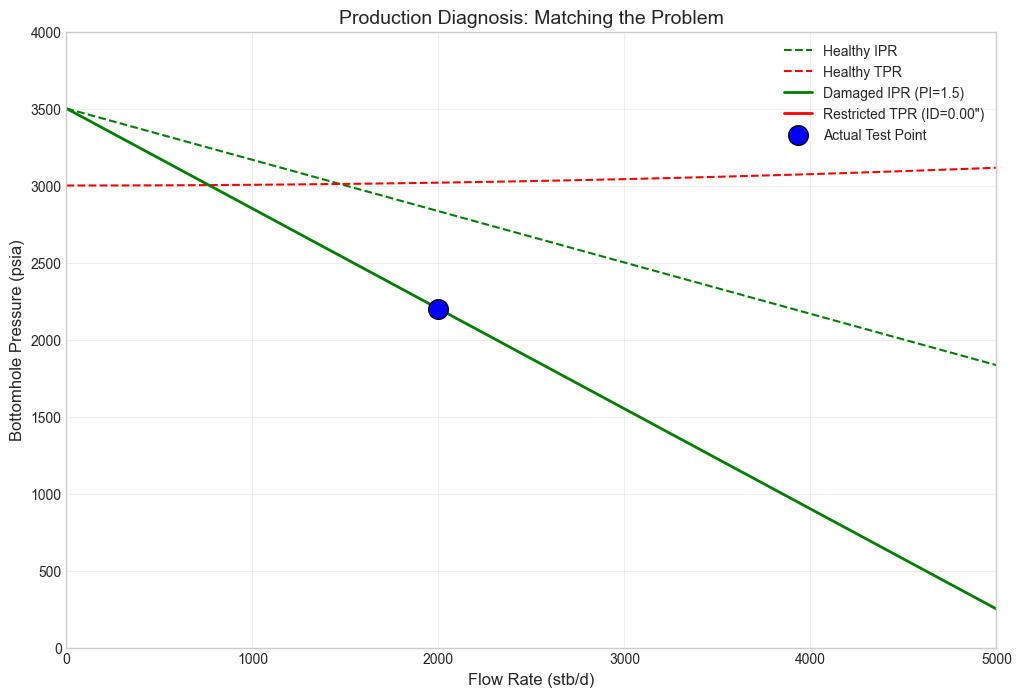

In [5]:
# Generate flow rates for plotting
q_space = np.linspace(0, 5000, 100)

plt.figure(figsize=(12, 8))

# 1. BASELINE (HEALTHY)
p_ipr_base = [get_ipr_pressure(q, p_res_base, pi_base) for q in q_space]
p_tpr_base = [get_tpr_pressure(q, p_wh_actual, tubing_id_base) for q in q_space]

plt.plot(q_space, p_ipr_base, 'g--', label='Healthy IPR')
plt.plot(q_space, p_tpr_base, 'r--', label='Healthy TPR')

# 2. HYPOTHESIS CURVES
# A. Damaged IPR
p_ipr_dam = [get_ipr_pressure(q, p_res_base, pi_damaged) for q in q_space]
plt.plot(q_space, p_ipr_dam, 'g-', linewidth=2, label=f'Damaged IPR (PI={pi_damaged:.1f})')

# B. Restricted TPR
p_tpr_res = [get_tpr_pressure(q, p_wh_actual, id_restricted) for q in q_space]
plt.plot(q_space, p_tpr_res, 'r-', linewidth=2, label=f'Restricted TPR (ID={id_restricted:.2f}")')

# 3. ACTUAL TEST POINT
plt.scatter(q_test, pwf_test, s=200, color='blue', edgecolors='black', zorder=10, label='Actual Test Point')

# Annotations
plt.title("Production Diagnosis: Matching the Problem", fontsize=14)
plt.xlabel("Flow Rate (stb/d)", fontsize=12)
plt.ylabel("Bottomhole Pressure (psia)", fontsize=12)
plt.legend()
plt.ylim(0, 4000)
plt.xlim(0, 5000)
plt.grid(True, alpha=0.3)

plt.show()

## 5. Summary & Conclusion
Look at the plot above. The **Blue Dot** (Actual Data) lies at the intersection of the Solid Green and Solid Red lines.

**How do we know which one is true?**
We cannot know from Pressure/Rate data alone! The math supports both hypotheses equally. We need **Secondary Diagnosis**:

1.  **Check Water Chemistry:** If Scale is suspected (Hypothesis B), check for calcium carbonate in produced water.
2.  **Run a Slickline/Gauge:** Tag bottom. If the tool stops early, it's a restriction (Hypothesis B).
3.  **Pressure Build-up Test:** Shut the well in. If Skin is high, it confirms Hypothesis A.

This notebook provides the **quantitative basis** to justify running those expensive diagnostic tools.